# hide
title: Alice visits a website
tags: privacy data ads

In [1]:
# hide
import re
import sys
import json
import urllib.parse
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import graphviz
from har import HarFile

In [32]:
# hide-code
class Graph:
    
    THEMES = {
        "user": {"fillcolor": "#a0f0a0"},
        "browser": {"fillcolor": "#e0e0e0"},
        "urchin": {"fillcolor": "#f0a0a0"},
        "website": {"shape": "box", "fillcolor": "#e0e0f0"},
        "static": {"shape": "house", "fillcolor": "#e0e0f0"},
    }
    
    def __init__(self, **kwargs):
        kwargs.setdefault("engine", "neato")
        self.dot = graphviz.Digraph(**kwargs)
        self.default_kwargs = {
            "fontname": "Helvetica"
        }
    
    def node(self, id: str, label: str, theme: str = None, **kwargs):
        merged_kwargs = self.default_kwargs.copy()
        merged_kwargs.update(kwargs)
        if theme in self.THEMES:
            merged_kwargs.update(self.THEMES[theme])
                
        merged_kwargs.setdefault("style", "filled")
        self.dot.node(id, label, **merged_kwargs)
    
    def edge(self, *args, **kwargs):
        merged_kwargs = self.default_kwargs.copy()
        merged_kwargs.update(kwargs)
        merged_kwargs.setdefault("fontsize", "12")
        self.dot.edge(*args, **merged_kwargs)
    
    def request(self, n1: str, n2: str, label: str = None, **kwargs):
        kwargs.setdefault("taillabel", label)
        kwargs.setdefault("color", "#a8a8a8")
        kwargs.setdefault("fontcolor", "#a8a8a8")
        self.edge(n1, n2, **kwargs)
    
    def response(self, n1: str, n2: str, label: str = None, **kwargs):
        kwargs.setdefault("taillabel", label)
        kwargs.setdefault("color", "#404070")
        kwargs.setdefault("fontcolor", "#404070")
        self.edge(n1, n2, **kwargs)
    

Alice wants to visit a website. She's clicking something in a browser and up comes the page.

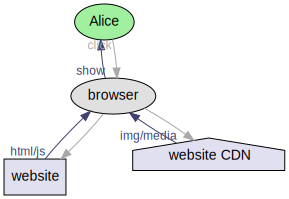

In [67]:
# hide-code
def alice_graph(with_urchin=False, urchin_length="2.0"):
    g = Graph()
    g.node("1", "website", "website")
    g.node("1c", "website CDN", "static")
    g.node("b", "browser", "browser")
    g.node("a", "Alice", "user")

    g.request("a", "b", "click")
    g.response("b", "a", "show")
    g.request("b", "1", len="1.5")
    g.response("1", "b", "html/js")
    g.request("b", "1c", len="1.5")
    g.response("1c", "b", "img/media")
    
    if with_urchin:
        g.node("u", "urchin", "urchin")
        g.request("b", "u", "Hey, i'm visiting website", len=urchin_length)
        g.response("u", "b", "display adds")
    return g

alice_graph().dot

The website's server delivers some [html](https://en.wikipedia.org/wiki/HTML) and other files to show the page. Huge files or stuff that is quickly needed everywhere may come from a [Content Delivery Network](https://en.wikipedia.org/wiki/Content_delivery_network) that the website runs, pays or simply relies on for free.

For example [jQuery](https://jquery.com/), a framework in javascript that helps making web pages more interactive and fancy and which may have saved javascript as language in web browsers from being overrun by something more convenient. Now this framework can be downloaded any time at `https://cdnjs.cloudflare.com/ajax/libs/jquery/3.6.0/jquery.min.js` or `https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js` or a dozen other places. So when i create a website using jquery i could deliver it myself along with the rest of my page or i tell the browser to get the file from one of the *CDN*s. *They* say that it's good for web performance because the browser might have it in 
[cache](https://en.wikipedia.org/wiki/Web_cache) already and must not necessarily load it. If it loads, though, it will send some information to the CDN like Alice's [IP address](https://en.wikipedia.org/wiki/IP_address), any associated [Cookies](https://en.wikipedia.org/wiki/HTTP_cookie) and possibly the name of the website Alice is visiting, for example [https://anonyme-alkoholiker.de](https://anonyme-alkoholiker.de).

Some websites simply don't do this. They deliver everything by themselves. Other websites do this extensively and require 10 other services to deliver [CSS](https://en.wikipedia.org/wiki/CSS) styles, fonts, images, scripts and whatever. The Alcoholics Anonymous website actually delivers it's own jQuery, but a sub-library of jQuery requires the CSS from `https://code.jquery.com/ui/1.11.4/themes/smoothness/jquery-ui.css?ver=5.6.2`.

But that's how websites get delivered. And, by the way, web development is very expensive, the websites need some revenue, so they place advertising on their page.

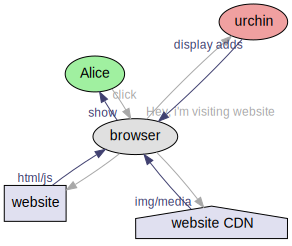

In [61]:
# hide-code
alice_graph(with_urchin=True).dot

The [Urchin](https://en.wikipedia.org/wiki/Urchin_\(software\)) might actually be a multinational corporation but in any case, the website owner does now allow the other network to place [banner ads](https://en.wikipedia.org/wiki/Web_banner), [web analytics](https://en.wikipedia.org/wiki/Web_analytics) or similiar things into it's own page. 

The owner of the website gets some money for each of Alice's clicks on a commercial, also he can study Alice's reasons for visiting his page and what stuff she looked at there. If he wants to see the statistics of all the visits on his page he goes to Urgin's website.    

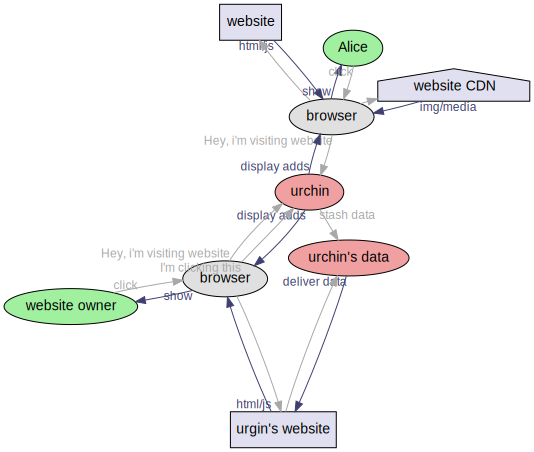

In [71]:
# hide-code
g = alice_graph(with_urchin=True, urchin_length="1.5")

g.node("o", "website owner", "user")
g.node("b2", "browser", "browser")
g.node("ud", "urchin's data", "urchin")
g.node("uw", "urgin's website", "website")

g.request("u", "ud", "stash data")

g.request("b2", "u", "Hey, i'm visiting website", len="1.5")
g.response("u", "b2", "display adds")

g.request("o", "b2", "click", len="2.")
g.response("b2", "o", "show")
g.request("b2", "uw", len="2.5")
g.response("uw", "b2", "html/js")
g.request("uw", "ud", len="2.5")
g.response("ud", "uw", "deliver data")

g.request("b2", "u", "I'm clicking this", len="1.5")
#g.response("u", "b2", "display adds")

g.dot

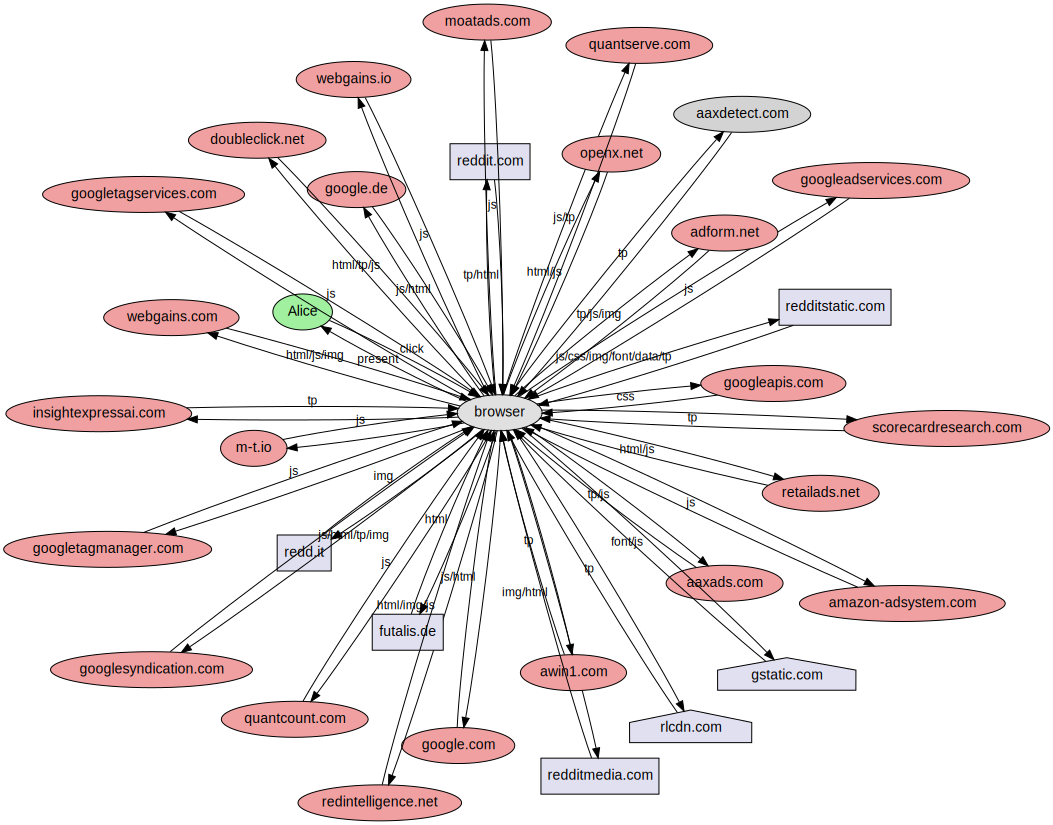

In [73]:

MIME_TYPES = {
    "html": "html",
    "javascript": "js",
    "font": "font",
    "css": "css",
    "image": "img",
    "octet-stream": "data",
}

HOST_THEMES = {
    "website": [
        re.compile("website"),
        re.compile("redd\.?it"),
        re.compile("futalis.de"),
    ],
    "static": [
        re.compile("gstatic"),
        re.compile("cdn"),
    ],
    "urchin": [
        re.compile("adform"),
        re.compile("ads"),
        re.compile("awin1.com"),
        re.compile("doubleclick"),
        re.compile("google"),
        re.compile("insightexpressai"),
        re.compile("redintelligence"),
        re.compile("m-t.io"),
        re.compile("openx\."),
        re.compile("quantcount"),
        re.compile("quantserve"),
        re.compile("scorecardresearch"),
        re.compile("webgains"),
    ],
}

def get_host_theme(host: str):
    for key, regs in HOST_THEMES.items():
        for r in regs:
            if r.findall(host):
                return key

g = Graph(engine="fdp")
g.node("b", "browser", "browser")
g.node("a", "Alice", "user")
g.edge("a", "b", label="click")
g.edge("b", "a", label="present")

har = HarFile("hars/ebay/*reddit*.har")

for data in har.connections():
    host = data["host"]
    g.node(host, host, get_host_theme(host))
    g.edge("b", host)
    if data["res"]:
        label = "/".join(
            sorted(data["res_type"].keys(), key=lambda k: -data["res_type"][k])
        )
        g.edge(host, "b", label=label)

g.dot

In [79]:
pd.DataFrame(cons)


,stern.de,upscore.com,meetrics.net,de.com,googlesyndication.com,google-analytics.com,criteo.net,googletagmanager.com,adform.net,ioam.de,...,opinary.com,outbrain.com,outbrainimg.com,cloudfront.net,intellitxt.com,pressekompass.net,smartclip.net,ampproject.org,akamaized.net,cloudflare.com
req,129,24,53,35,79,33,10,4,28,10,...,16,36,9,3,43,13,7,5,1,1
req_cookie,899,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,0
req_param,75,0,53,33,647,302,5,4,40,167,...,12,478,29,12,100,24,89,0,1,0
req_param_len,4932,0,45166,34002,14712,5086,160,52,7424,2991,...,241,10328,571,306,3601,2802,2872,0,120,0
res,129,24,53,35,79,33,10,4,28,10,...,16,36,9,3,43,13,7,5,1,1
res_cookie,14,0,0,0,0,0,0,0,4,6,...,0,26,0,0,18,0,7,0,0,0
res_type,"{'html': 11, 'js': 44, 'data': 19, 'css': 15, ...",{'js': 5},{'img': 53},"{'img': 33, 'js': 2}","{'img': 32, 'html': 10, 'js': 27}","{'img': 22, 'js': 6}","{'img': 3, 'js': 7}",{'js': 4},"{'img': 18, 'js': 10}",{'js': 9},...,{'js': 3},"{'js': 12, 'html': 6, 'img': 6}",{'img': 3},{'img': 3},"{'js': 16, 'css': 3, 'html': 2, 'img': 9, 'dat...","{'html': 2, 'css': 2, 'js': 6, 'img': 2}","{'js': 4, 'img': 3}",{'js': 5},{},{'js': 1}


In [68]:
import requests
requests.get("https://awin1.com").text

'<!DOCTYPE html><html lang="de-DE" itemscope id="top" class="no-js"><head><meta charset="utf-8"><meta http-equiv="x-ua-compatible" content="IE=edge"><meta name="viewport" content="width=device-width initial-scale=1"><meta name="format-detection" content="telephone=no"><title>Wir sind Affiliate Marketing - Das Affiliate-Netzwerk Awin stellt sich vor | Awin</title><link rel="stylesheet" href="/styles/site.css?1614890392874"><meta name="apple-mobile-web-app-title" content="Awin"><meta name="application-name" content="Awin"><meta name="msapplication-TileColor" content="#fd6149"><meta name="theme-color" content="#fd6149"><meta name="description" content="Unser globales Affiliate-Netzwerk verbindet Advertiser und Publisher deren Online-Erfolg wir täglich steigern. Werde noch heute ein Teil davon."><meta property="og:site_name" content="Awin"><meta property="og:title" content="Wir sind Affiliate Marketing - Das Affiliate-Netzwerk Awin stellt sich vor | Awin"><meta property="og:url" content="h